In [1]:
%load_ext Cython

import numpy
from scipy.optimize import minimize, minimize_scalar
from scipy import signal
import pandas
import seaborn

import matplotlib.pyplot as plt
%matplotlib inline
plot.rcParams['figure.figsize'] = (16.0, 7.0)

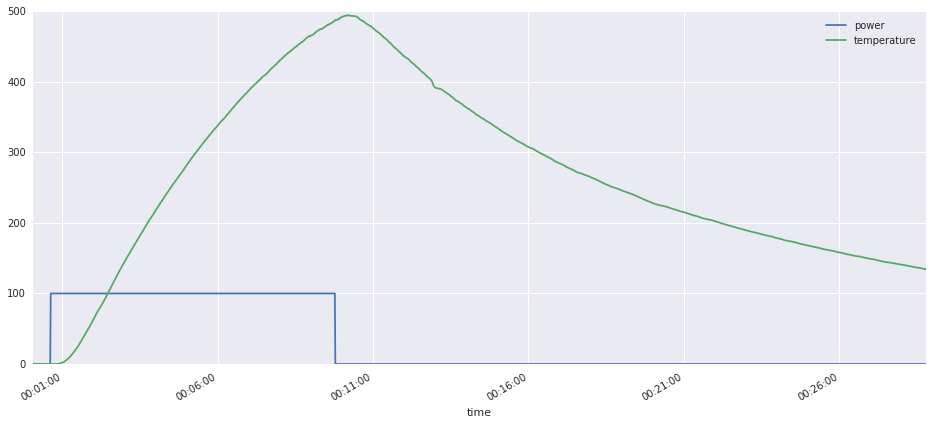

In [2]:
#d = pandas.read_csv("experiments/old/plytele3.csv")
d = pandas.read_csv("experiments/maxima.csv")
del d['setpoint']
del d['time']

# Remove rows containing errors
d = d[d.notnull().T.all()]
d.temp_inside = pandas.rolling_median(d.temp_inside, 3)
d.temp_outside = pandas.rolling_median(d.temp_outside, 3)
d = d[d.notnull().T.all()]

d.time = d.local_time
del d['local_time']
d.index = pandas.to_datetime(d.time, unit='s')
d.index.name = 'time'

d['temperature'] = d.temp_inside - numpy.min(d.temp_inside)
d.temperature.name = 'temperature'
del d['temp_inside']
del d['temp_outside']

sampling_period = numpy.mean(d.time[1:] - numpy.array(d.time[:-1]))
sampling_frequency = 1 / sampling_period

def plot_reference(d):
    (d.power * 100).plot()
    d.temperature.plot()
    plt.legend()
plot_reference(d)

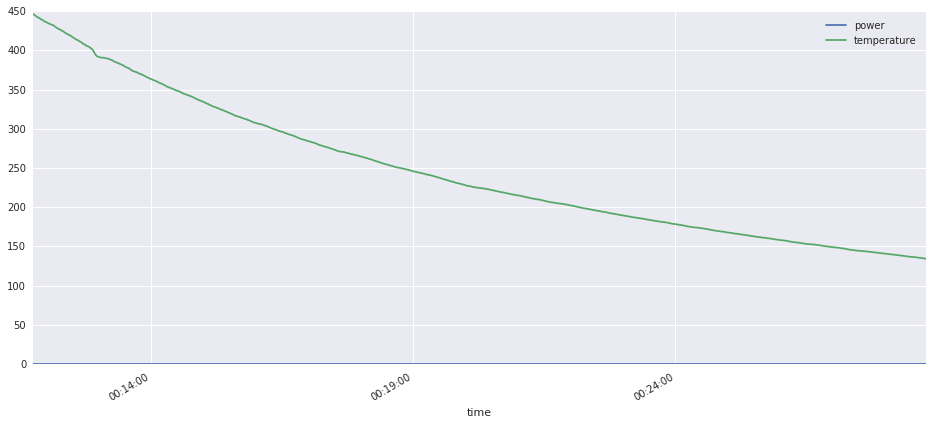

In [3]:
last_heating_index = numpy.max(numpy.where(d.power > 0))
d_cooling = d[last_heating_index + int(120 / sampling_period):]
plot_reference(d_cooling)

In [10]:
from model import *

In [24]:
model = TemperatureModel(sampling_period,
                         th_max=500,
                         heating_rc=371,
                         cooling_rc=738,
                         p_rc=150)

In [25]:
for i in range(30):
    print(i, end=' ')
    model.optimize(d_cooling,
                   fields=('cooling_rc',),
                   initial=(numpy.random.pareto(1),),
                   bounds=((1e-3, None),))

0 optimize[optimization_cooling_rc]: Better fitness achieved: 80874.31167364879 [ 0.00667881]
1 optimize[optimization_cooling_rc]: Better fitness achieved: 196.32581257290667 [ 738.42932978]
2 3 optimize[optimization_cooling_rc]: Better fitness achieved: 196.32581244218997 [ 738.428056]
4 5 6 7 8 9 10 11 12 13 14 optimize[optimization_cooling_rc]: Better fitness achieved: 196.32581244150143 [ 738.42777912]
15 16 17 18 19 20 21 optimize[optimization_cooling_rc]: Better fitness achieved: 196.32581244059662 [ 738.42790726]
22 23 24 25 26 27 28 29 

In [26]:
for i in range(30):
    print(i, end=' ')
    model.optimize(d,
                   fields=('heating_rc',),
                   initial=(numpy.random.pareto(1),),
                   bounds=((1e-3, None),))


0 optimize[optimization_heating_rc]: Better fitness achieved: 558.8315219405699 [ 389.3457829]
1 optimize[optimization_heating_rc]: Better fitness achieved: 558.8315218920089 [ 389.3456327]
2 3 4 5 optimize[optimization_heating_rc]: Better fitness achieved: 558.8315218892063 [ 389.34560819]
6 7 8 9 10 11 12 13 14 15 optimize[optimization_heating_rc]: Better fitness achieved: 558.8315218885671 [ 389.34554506]
16 17 18 19 optimize[optimization_heating_rc]: Better fitness achieved: 558.8315218879611 [ 389.34555692]
20 21 22 23 24 25 26 27 28 29 

In [14]:
for i in range(50):
    print(i, end=' ')
    model.optimize(d,
                   fields=('p_rc',),
                   initial=(numpy.random.pareto(1),),
                   bounds=((1e-3, None),))

0 optimize[optimization_p_rc]: Better fitness achieved: 243.97285505734476 [ 1.62280948]
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

TemperatureModel(
    dt=1,
    th_max=500,
    heating_rc=389.3455569170953,
    cooling_rc=738.4279072595713,
    p_rc=150,
)
optimize_heating:p: 52.659240540704815 0.05275872618286822
optimize_heating:tf: 541.7032991068112 1.0618050409389392
optimize_heating:p: 52.659240540704815 0.05275872618286822
optimize_heating:tf: 1845.6097836388474 1.2261923341840653
optimize_heating:p: 52.659240540704815 0.05275872618286822
optimize_heating:tf: 429.0599610544375 0.9543903379141077


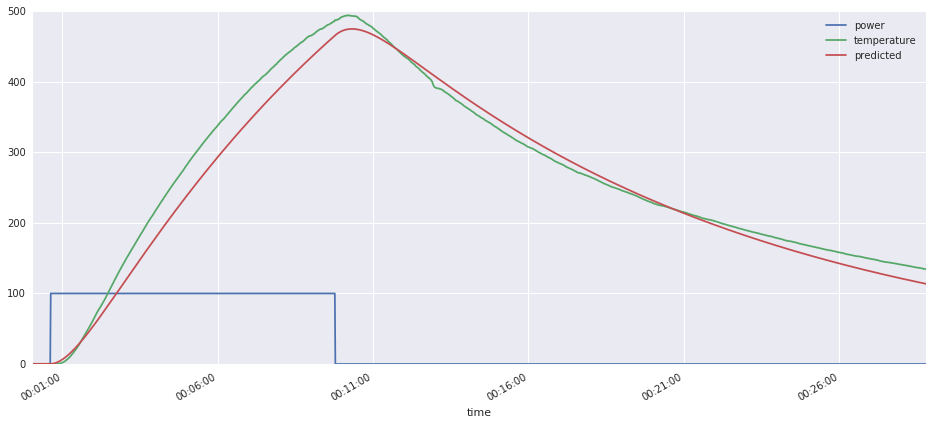

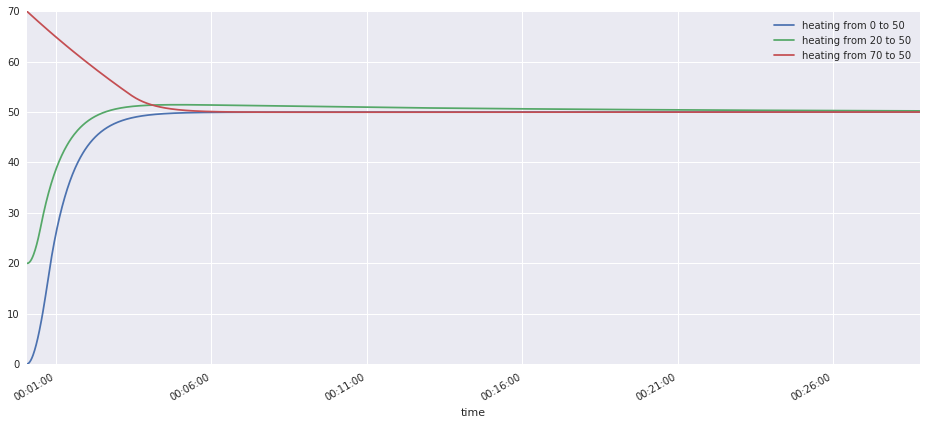

In [27]:
model.show()
plot_reference(d)
pandas.Series(model.reference_predict(d), index=d.index, name='predicted').plot()
plt.legend()

def heating_plot(p0, th0, th1):
    p, tf, vf = model.optimize_heating(th0, th1, p0)
    pandas.Series(model.heating_predict(len(d), th0, th1, p0, p, tf, vf),
              index=d.index,
              name='heating from {} to {}'.format(th0, th1)).plot()

plt.figure()    
p0 = 0.0
th1 = 50
heating_plot(p0, 0, th1)
heating_plot(p0, 20, th1)
heating_plot(p0, 70, th1)
plt.legend()